In [7]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [6]:
%cd ..

/home/ec2-user/SageMaker


In [9]:
from src.model import model_TT, model_table, sop

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [11]:
def extract_line(df_ocr, df_area):
    data=[]
    bold=[]
    for idn,model_row in df_area.iterrows():
        tp_bbx=[0,int(model_row.y_1),int(model_row.page_width),int(model_row.y_2)]
        words= []
        is_bold = []
        for idx,ocr_row in df_ocr.iloc[:,:4].iterrows():
            word_bbx=ocr_row.astype(int).values
            flag=check_point(tp_bbx,word_bbx)
            if flag:
                words.append(df_ocr.iloc[idx]['text'].strip())
                is_bold.append(df_ocr.iloc[idx]['is_bold'])
        bold.append(is_bold)
        data.append(words)
    return data,bold


def check_title(df):
    final=[]
    for i,row in df.iterrows():
        if row.type in ['Title','text']:
            if (row.is_upper==True) and (row.word_length<5) and (row.is_bold==True):
                final.append("Title")
            else:
                final.append("Text")
        else:
             final.append(row.type)
    df["final_type"] = final
    return df

In [12]:

def load_ocr(filename=None):
    pdf_layout, pdf_images = sop.load_pdf(filename,load_images=True)
    ocr_data=[]
    for page_index,ocr in enumerate(pdf_layout):
        image=np.array(pdf_images[page_index])
        df=ocr.to_dataframe()
        df["page_index"]=page_index
        df["height"] = abs(df.y_1-df.y_2)
        df['width'] = abs(df.x_1-df.x_2)
        df['page_width'] = image.shape[1]
        df['page_height'] = image.shape[0]
        df['clen_type']=df.type.apply(lambda x: x.lower())
        df['is_bold']=df.clen_type.str.contains('bold')
        ocr_data.append(df)
    ocr_df=pd.concat([x for x in ocr_data])
    return ocr_df,pdf_images
    

def layout_model(image,page_index=0, table=True):
    data=[]
    if table:
        table_layout=model_table.detect(image)
        image=mask_image(table_layout.to_dataframe(),image)
        data.append(table_layout.to_dataframe())
    layout=model_TT.detect(image)
#     sop.draw_box(image.copy(),layout,show_element_type=True)
    data.append(layout.to_dataframe()) 
    df=pd.concat([x for x in data])
    df["page_index"] = page_index
    df["height"] = abs(df.y_1-df.y_2)
    df['width'] = abs(df.x_1-df.x_2)
    df['page_width'] = image.shape[1]
    df['page_height'] = image.shape[0]
    df = df.sort_values(by=['y_1'], ascending=True)
    
    return df

def is_header_footer(ocr_df):
    ocr_df["combine_info"]= ocr_df[['x_1','y_1','x_2','y_2','text','height','width']].apply(lambda x: ','.join([str(p) for p in x]) ,axis=1)
    ocr_df["is_header_footer"]=ocr_df.combine_info.duplicated()
    return ocr_df

def is_bulit(ocr_df):
    title_index=["1.0",'2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0']
    ocr_df['is_start_bulit']=ocr_df.text.apply(lambda x : x in title_index)
    return ocr_df


In [13]:
# word
def get_center(x1,y1,x2,y2):
    xCenter = (x1 + x2) / 2
    yCenter = (y1 + y2) / 2
    return xCenter,yCenter

def FindPoint(x1, y1, x2,
              y2, x, y) :
    if (x > x1 and x < x2 and
        y > y1 and y < y2) :
        return True
    else :
        return False
    
def check_point(tt_box,word_bbx):
    point_x,point_y = get_center(word_bbx[0],word_bbx[1],
                                 word_bbx[2],word_bbx[3])
    return FindPoint(tt_box[0],tt_box[1],
                     tt_box[2],tt_box[3],point_x,point_y)

In [14]:
def extract_words(df_ocr, page_index, layout_df):
    df_ocr=df_ocr[df_ocr.page_index==page_index]
    df_area = layout_df.sort_values(by=['y_1'], ascending=True)
    data=[]
    for idn,model_row in df_area.iterrows():
        tp_bbx=model_row[:4].astype(int).values
        para_data = {}
        word_index=[]
        words= []
        for idx,ocr_row in df_ocr.iloc[:,:4].iterrows():
            word_bbx=ocr_row.astype(int).values
            flag=check_point(tp_bbx,word_bbx)
            if flag:
                word_index.append(idx)
                words.append(df_ocr.iloc[idx]['text'])
                
        para_data["page_index"]=model_row.page_index
        para_data["type"]=model_row.final_type
#         para_data["word_index"]=word_index
        para_data['words'] = words
        content=" ".join([df_ocr.iloc[x]['text'] for x in word_index])
        strencode = content.encode("ascii", "ignore")
        #decode() method
        strdecode = strencode.decode()
 
        para_data['text']=strdecode
        data.append(para_data)
    
    return data

In [15]:
def mask_image(df,page_image):
    for x in df.iloc[:,:4].astype(int).values:
        page_image = cv2.rectangle(page_image, tuple(x[:2]),tuple(x[2:]),[255,255,255],-1)
    return page_image

def clean_image(image, ocr_df, page_index):
    page_id=page_index
    ocr_df=is_bulit(ocr_df)
    ocr_df=is_header_footer(ocr_df)
    select_page = ocr_df[ocr_df.page_index==page_id]
    remove_header_footer = select_page[select_page.is_header_footer==True]
    remove_bulit = select_page[select_page.is_start_bulit==True]
    
    image_header=mask_image(remove_header_footer, image)
    _image = mask_image(remove_bulit, image_header)
    
    return _image

In [16]:
def correct_df_area(page_ocr,page_index,page_area):
    page_ocr=page_ocr[page_ocr.page_index==page_index]
    sent,bold=extract_line(page_ocr,page_area)
    page_area["data"]=sent
    page_area["is_bold"]=[all(list_bold) for list_bold in bold]
    page_area["clean_data"]=[" ".join(x) for x in sent]
    page_area['word_length']=page_area.data.apply(lambda x: len(x))
    page_area['is_upper']=page_area.clean_data.apply(lambda x: x.isupper())
    update_df=check_title(page_area)
    return update_df

In [18]:
file_name = "sop/SOP-13008.pdf"
ocr_df, pdf_images =load_ocr(file_name)

In [28]:
page_index = 5
image=np.asarray(pdf_images[page_index])
image= clean_image(image,ocr_df,page_index)
layout_df=layout_model(image,page_index)
layout_df=correct_df_area(ocr_df,page_index,layout_df)
data = extract_words(ocr_df,page_index,layout_df)

In [29]:
layout_df

,x_1,y_1,x_2,y_2,block_type,type,score,page_index,height,width,page_width,page_height,data,bold,clean_data,word_length,is_upper,final_type
1,107.855255,85.046555,281.282196,100.459419,rectangle,Title,0.966113,5,15.412865,173.426941,596,842,"[6.0, EQUIPMENT, AND, MATERIALS]",True,6.0 EQUIPMENT AND MATERIALS,4,True,Title
0,156.938873,97.488617,484.292664,558.028992,rectangle,List,0.990294,5,460.540375,327.353790,596,842,"[6.1, Equipment, , Waters, Alliance, Separati...",False,6.1 Equipment  Waters Alliance Separations Mo...,142,False,List


In [25]:
# " ".join(x for x in data[5]['words'])

In [26]:
# with open('speechbase.json', 'w') as jsonfile:
# 	json.dump(data, jsonfile, indent = 4)
# open("16.json" , "w", encoding="utf-8").write(json.dumps(data,indent=4, ensure_ascii=False))

In [27]:
# import glob
# import json 
# files =glob.glob("sop/*.pdf")
# for fi in files:
#     file_name = fi
#     ocr_df, pdf_images =load_ocr(file_name)
#     data_whole={}
#     for _ in range(len(pdf_images)):
#         page_index = _
#         image=np.asarray(pdf_images[page_index])
#         image= clean_image(image,ocr_df,page_index)
#         layout_df=layout_model(image,page_index)
#         layout_df=correct_df_area(ocr_df,page_index,layout_df)
#         data = extract_words(ocr_df,page_index,layout_df)
#         data_whole[f'page_no_{_}']= data
#     open(f"{fi.split('.')[0]}.json" , "w", encoding="utf-8").write(json.dumps(data,indent=4, ensure_ascii=False))


In [23]:
files =glob.glob("sop/*.pdf")

In [29]:
fi.split('.')

['sop/SOP-13024', 'pdf']

In [19]:
import json 

In [20]:
out_file = open("109267.json", "w")
json.dump(data_whole, out_file, indent = 6)
out_file.close()

In [60]:
layout_df

,x_1,y_1,x_2,y_2,block_type,type,score,page_index
3,107.673714,71.656944,163.744263,86.622429,rectangle,Title,0.946517,2
2,71.424194,99.726509,519.761658,140.975479,rectangle,Text,0.966808,2
6,107.458801,153.086319,217.581512,168.668137,rectangle,Title,0.851661,2
4,72.045692,167.069702,507.129730,209.479324,rectangle,Text,0.902668,2
0,70.522202,222.131348,524.607239,304.174500,rectangle,Text,0.991687,2
1,108.123070,329.290619,220.585159,344.121277,rectangle,Title,0.981165,2
5,102.014938,329.520691,530.367432,741.483459,rectangle,List,0.869125,2
7,144.128540,717.942261,521.778076,745.008240,rectangle,Text,0.676699,2


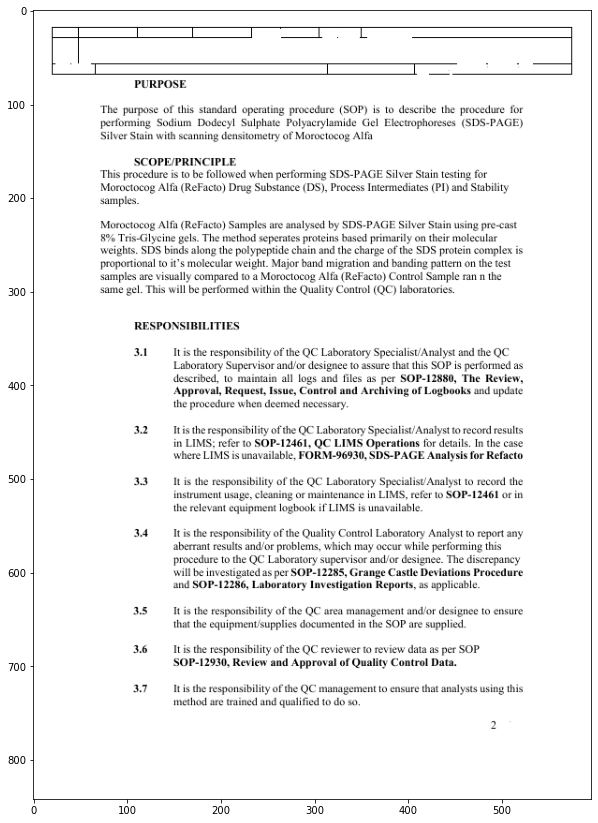

In [49]:
plt.figure(figsize=(10,20))
plt.imshow(cln_image)


In [11]:
# df=layout_model(pdf_images[10],10)

In [12]:
# df.sort_values(by="y_1")

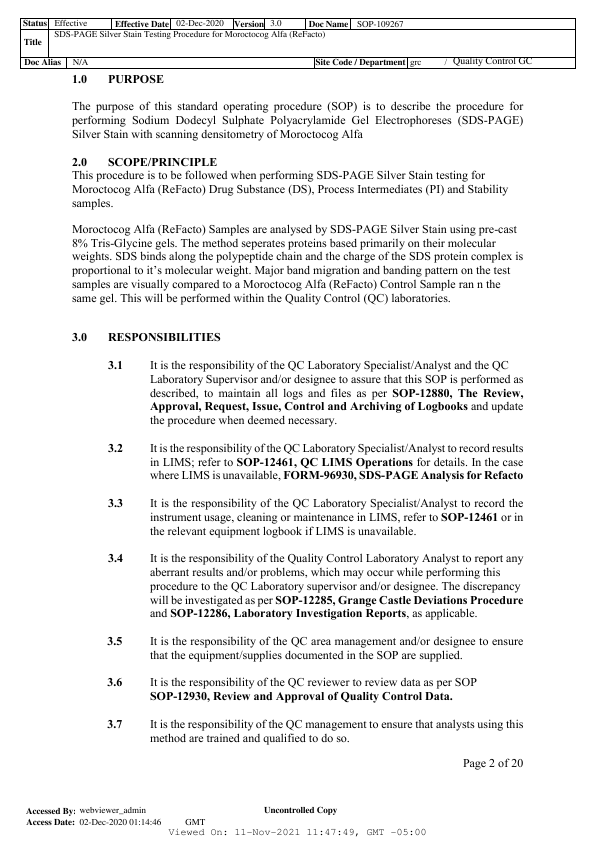

In [48]:
pdf_images[2]

In [14]:
" ".join(data[0]['words'])

'It is the responsibility of the Quality Group to review and approve this procedure.'

In [21]:
image=layout_dfarray(pdf_images[3])